In [1]:
import pystac_client
import json
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import skimage as ski
import planetary_computer
import rasterio as rio
import numpy as np
from skimage.exposure import rescale_intensity
from rasterio.enums import Resampling
from rasterio.merge import merge
import rasterio.windows as windows
import rasterio.transform as transform

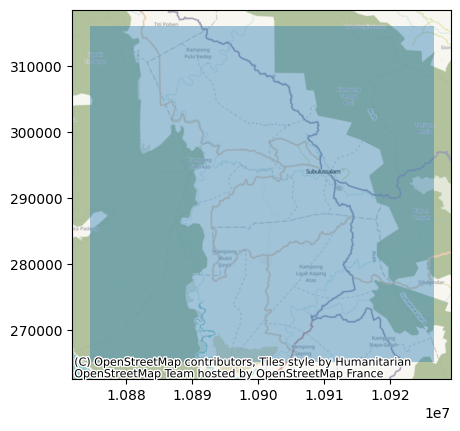

In [2]:
# Load the shapefile
roi = gpd.read_file('../data/roi/example_roi_north_sumatera.shp')

# Plot it
ax = roi.to_crs(epsg=3857).plot(alpha=0.4)
cx.add_basemap(ax)

In [3]:
# Load stac address
stac = json.load(open('../data/stac.json'))
link = stac['mpc']

# Load STAC
client = pystac_client.Client.open(link, modifier=planetary_computer.sign_inplace)

# Get liss of all collection
collections = [x for x in client.get_collections()]
collections

[<CollectionClient id=daymet-annual-pr>,
 <CollectionClient id=daymet-daily-hi>,
 <CollectionClient id=3dep-seamless>,
 <CollectionClient id=3dep-lidar-dsm>,
 <CollectionClient id=fia>,
 <CollectionClient id=sentinel-1-rtc>,
 <CollectionClient id=gridmet>,
 <CollectionClient id=daymet-annual-na>,
 <CollectionClient id=daymet-monthly-na>,
 <CollectionClient id=daymet-annual-hi>,
 <CollectionClient id=daymet-monthly-hi>,
 <CollectionClient id=daymet-monthly-pr>,
 <CollectionClient id=gnatsgo-tables>,
 <CollectionClient id=hgb>,
 <CollectionClient id=cop-dem-glo-30>,
 <CollectionClient id=cop-dem-glo-90>,
 <CollectionClient id=goes-cmi>,
 <CollectionClient id=terraclimate>,
 <CollectionClient id=nasa-nex-gddp-cmip6>,
 <CollectionClient id=gpm-imerg-hhr>,
 <CollectionClient id=gnatsgo-rasters>,
 <CollectionClient id=3dep-lidar-hag>,
 <CollectionClient id=io-lulc-annual-v02>,
 <CollectionClient id=conus404>,
 <CollectionClient id=3dep-lidar-intensity>,
 <CollectionClient id=3dep-lidar-point

In [38]:
# Parameter for search
# BBOX or boundary
bbox = roi.bounds.iloc[0]

# Look for certain ranges of date
# Use 4 months between 2024 may to 2024 august
start = '2024-04'
end = '2024-09'

# Use the landsat collection 2 level surface reflectance
# Filter only landsat 8 and 9
# Flter only tier 1 data (the good one)
search = client.search(
	collections=['landsat-c2-l2'],
	bbox=bbox,
	datetime=f'{start}/{end}',
	filter={
		"op": "and",
		"args": [
			{ "op": "or", "args": [
				{ "op": "=", "args": [ { "property": "platform" }, "landsat-8"] },
				{ "op": "=", "args": [ { "property": "platform" }, "landsat-9"] }
			] },
			{ "op": "=" , "args": [ { "property": "landsat:collection_category" }, "T1" ] }
		]
	}
)

# List of data
data_list = [x for x in search.items_as_dicts()]
print(f'Images count: {len(data_list)}')
data_list

Images count: 41


[{'id': 'LC08_L2SP_129059_20240925_02_T1',
  'bbox': [96.9395052495526,
   0.3931643456501689,
   98.98485487411644,
   2.494465654349831],
  'type': 'Feature',
  'links': [{'rel': 'collection',
    'type': 'application/json',
    'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2'},
   {'rel': 'parent',
    'type': 'application/json',
    'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2'},
   {'rel': 'root',
    'type': 'application/json',
    'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/'},
   {'rel': 'self',
    'type': 'application/geo+json',
    'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2/items/LC08_L2SP_129059_20240925_02_T1'},
   {'rel': 'cite-as',
    'href': 'https://doi.org/10.5066/P9OGBGM6',
    'title': 'Landsat 8-9 OLI/TIRS Collection 2 Level-2'},
   {'rel': 'via',
    'href': 'https://landsatlook.usgs.gov/stac-server/collections/landsat-c2l2

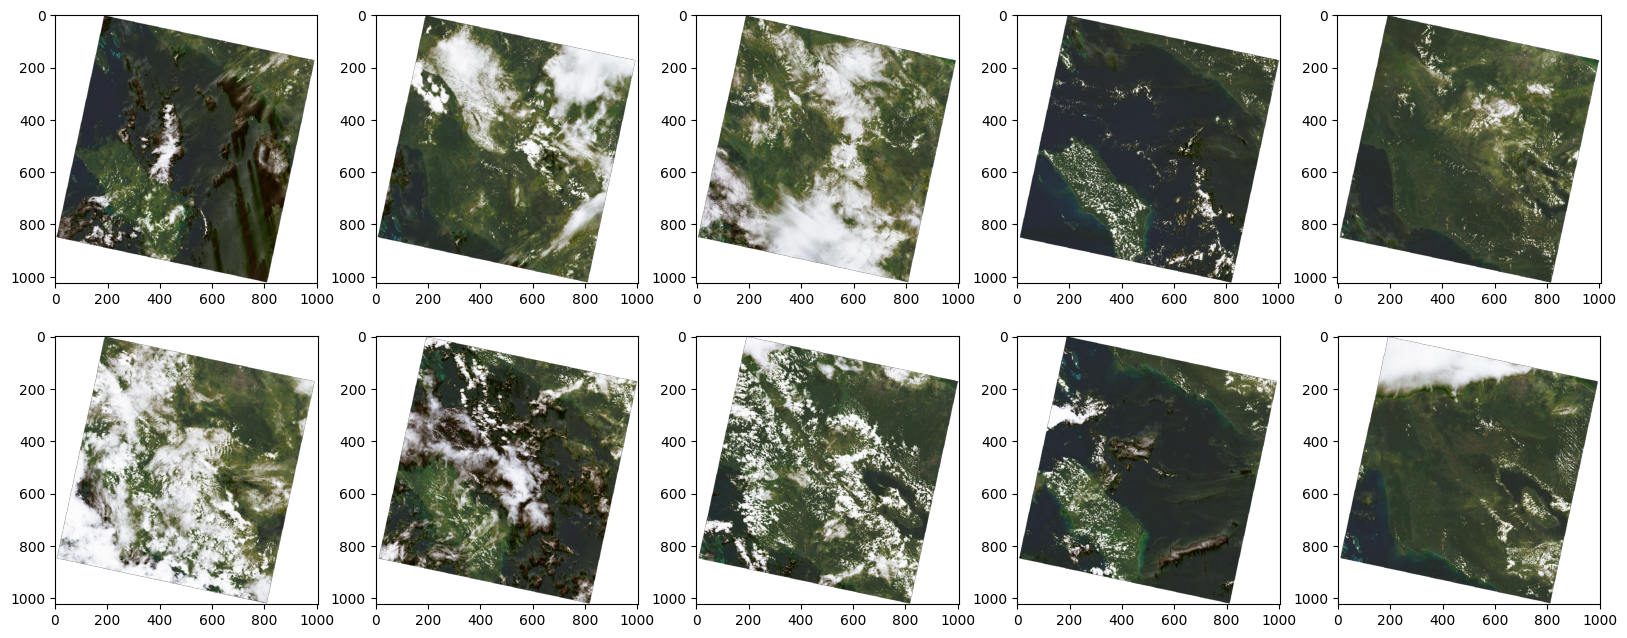

In [39]:
# Plot thumbnail every images
plt.figure(figsize=(20, 16))

# Load as plot
# Only the first 10
for x in range(0, len(data_list)):
	if (x < 10):
		dict = data_list[x]
		thumbnail = dict['assets']['rendered_preview']['href']
		image = ski.io.imread(thumbnail)
		plt.subplot(4, 5, x + 1)
		plt.imshow(image)

C:\Users\ramiq\AppData\Local\Temp\ipykernel_10356\1408146106.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  merge_dem, dem_transform = merge(dem_sources, bounds=(bbox[0], bbox[1], bbox[2], bbox[3]))


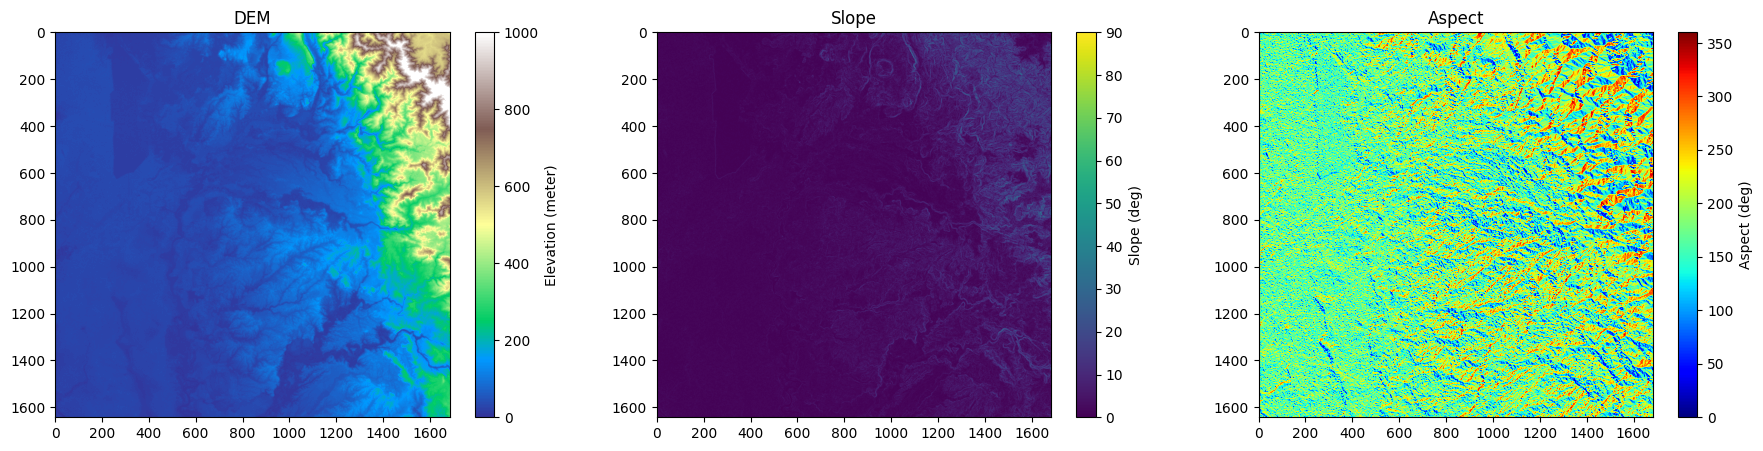

In [41]:
# Search DEM data
dem_data_search = client.search(
	collections=['nasadem'],
	bbox=bbox
)

# Load DEM as rio
dem_sources = [rio.open(x['assets']['elevation']['href']) for x in dem_data_search.items_as_dicts()]

# Merge DEM
merge_dem, dem_transform = merge(dem_sources, bounds=(bbox[0], bbox[1], bbox[2], bbox[3]))
merge_dem = merge_dem[0]

# DEM shape
dem_shape = merge_dem.shape

# Plot
plt.figure(figsize=(22, 5))

# Plot DEM
plt.subplot(1, 3, 1)
plt.title('DEM')
plt.imshow(merge_dem, vmin=0, vmax=1000, cmap='terrain')
plt.colorbar(label='Elevation (meter)')

# Pi
pi = 3.14159265359

# Make slope
py, px = np.gradient(merge_dem, 100)
slope = np.sqrt((px ** 2) + (py ** 2))
slope_deg = slope / 1 * 90
slope_rad = slope_deg / 180 * pi
plt.subplot(1, 3, 2)
plt.title('Slope')
plt.imshow(slope_deg, vmin=0, vmax=90)
plt.colorbar(label='Slope (deg)')

# Make aspect
aspect = np.arctan2(py, -px)
aspect_normalized = np.degrees(aspect)
aspect_normalized = (aspect_normalized + 360) % 360
aspect_rad = aspect_normalized / 180 * pi

plt.subplot(1, 3, 3)
plt.title('Aspect')
plt.imshow(aspect_normalized, vmin=0, vmax=360, cmap='jet')
plt.colorbar(label='Aspect (deg)')

In [ ]:
# Load the tif images
plt.figure(figsize=(20, 10))

# Select the bands needed
bands = ['coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22']
qband = 'qa_pixel'

# Load bands
cloud_masked_images = []
cloud_topo_images = []
for x in range(0, len(data_list)):
	# Get dict of data in the items
	assets = data_list[x]['assets']

	# Get the quality band
	qband_source = rio.open(assets[qband]['href'])

	# Make window to read file only on specific part
	# Using our ROI BBOX to limit read
	qband_transform = qband_source.transform

	# Create a bbox based on the CRS of the image
	bbox_small = roi.to_crs(qband_source.crs).bounds.iloc[0]

	# Window to read the imagew
	window = windows.from_bounds(bbox_small[0], bbox_small[1], bbox_small[2], bbox_small[3], qband_transform)

	# Qband raster
	qband_image = qband_source.read(1, window=window, boundless=True, fill_value=1, out_shape=(dem_shape[0], dem_shape[1]))

	# Make cloud mask
	cloud_mask = (qband_image != 1) & ((qband_image & (1 << 1)) == 0) & ((qband_image & (1 << 2)) == 0) & ((qband_image & (1 << 3)) == 0)

	# Cloud masked image
	# Load source each band
	sources = [rio.open(assets[y]['href']) for y in bands]

	# Make into 1 stack
	stack = np.stack([source.read(1, window=window, boundless=True, fill_value=-9999, out_shape=(dem_shape[0], dem_shape[1])) for source in sources]) * 0.0000275 + -0.2

	# Apply cloud mask per band
	for y in range(0, len(stack)):
		stack[y][cloud_mask == 0] = -9999

	# Add each image to the list of images
	cloud_masked_images.append(stack)

	# Make composite using NIR SWIR1 SWIR2
	# Only 20 bands
	if (x < 20):
		# Make range into 0 - 1
		out_range = (0, 1)
		composite = np.dstack([
			rescale_intensity(stack[4], in_range=(0.1, 0.4), out_range=out_range),
			rescale_intensity(stack[5], in_range=(0.05, 0.3), out_range=out_range),
			rescale_intensity(stack[6], in_range=(0.025, 0.25), out_range=out_range),
		])

		# Plot
		plt.subplot(4, 5, x + 1)
		plt.imshow(composite)

	# Read asset properties
	properties = data_list[x]['properties']

	# Get the angle parameter for topographic correction
	azimuth_rad = properties['view:sun_azimuth'] * pi / 180
	elevation = properties['view:sun_elevation']
	zenith_rad = (elevation - 90) * pi / 180

	# Another parameter for topographic correction
	cos_zenith = np.cos(zenith_rad)
	cos_slope = np.cos(slope_rad)
	slope_illumination = cos_zenith * cos_slope
	sin_zenith = np.sin(zenith_rad)
	sin_slope = np.sin(slope_rad)
	cos_azmiuth_dif = np.cos(azimuth_rad - aspect_rad)
	aspect_illumination = sin_zenith * sin_slope * cos_azmiuth_dif
	incidence_angle = slope_illumination + aspect_illumination

	# Mask to do topographic correction
	mask_topo = (slope_deg >= 5) & (incidence_angle >= 0) & (cloud_mask == 1)
	mask_topo_1d = mask_topo.reshape(-1)

	# Incidence angle in 1 dimension
	ic_1d = incidence_angle.reshape(-1)[mask_topo_1d]

	# Copy of cloud masked image
	copy_image = stack.copy()

	# Do regression per band with incidence angle
	for y in range(0, len(copy_image)):
		# Get both only useful array
		image_band_1d = copy_image[y].reshape(-1)[mask_topo_1d]

		# If there is a valid data, do the regression
		if (len(image_band_1d) & len(ic_1d)):
			# Get the scale and offset of
			scale, offset = np.polyfit(ic_1d, image_band_1d, 1)

			# C data
			c = offset / scale

			# Apply topographic correction only to masked area
			copy_image[y] = np.where(mask_topo == 1, copy_image[y] * (cos_slope * cos_zenith + c) / (incidence_angle + c), copy_image[y])

	# Add each image to the list of images
	cloud_topo_images.append(copy_image)

# Make list of images as numpy stack
cloud_masked_images = np.stack(cloud_masked_images)
cloud_topo_images = np.stack(cloud_topo_images)

C:\Users\ramiq\AppData\Local\Temp\ipykernel_10356\2171182215.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window = windows.from_bounds(bbox_small[0], bbox_small[1], bbox_small[2], bbox_small[3], qband_transform)


C:\Users\ramiq\AppData\Local\Temp\ipykernel_10356\3526935362.py:7: RuntimeWarning: All-NaN slice encountered
  cloud_masked_median = np.nanmedian(cloud_masked_images_ma, 0)
C:\Users\ramiq\AppData\Local\Temp\ipykernel_10356\3526935362.py:25: RuntimeWarning: All-NaN slice encountered
  cloud_topo_median = np.nanmedian(cloud_topo_images_ma, 0)


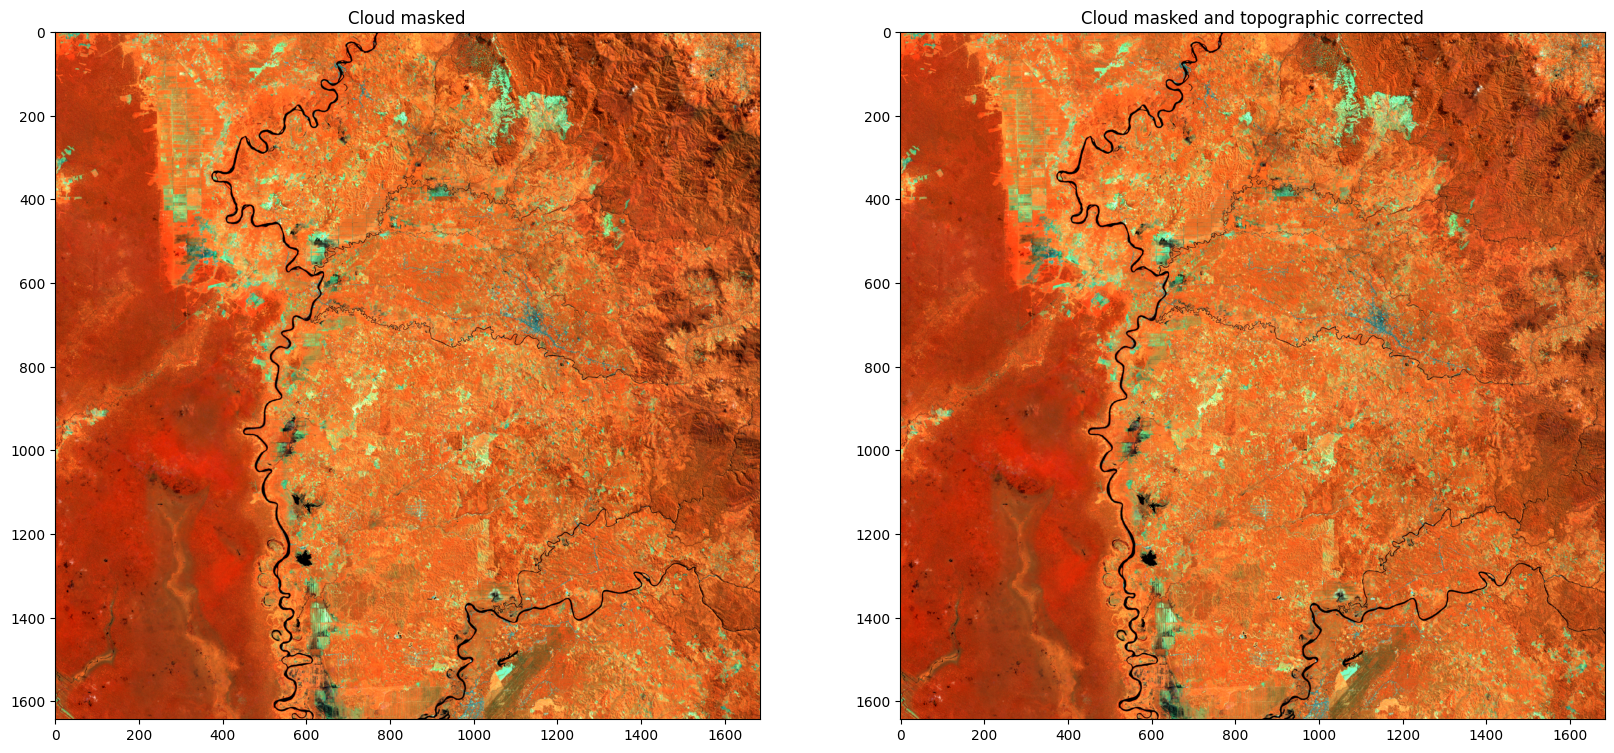

In [ ]:
plt.figure(figsize=(20, 10))

## Cloud masked ##

# Median composite along its 0 axis
cloud_masked_images_ma = np.ma.masked_where(cloud_masked_images < 0, cloud_masked_images)
cloud_masked_median = np.nanmedian(cloud_masked_images_ma, 0)

# Composite median for visualization
composite = np.dstack([
	rescale_intensity(cloud_masked_median[4], in_range=(0.1, 0.4), out_range=(0, 1)),
	rescale_intensity(cloud_masked_median[5], in_range=(0.05, 0.3), out_range=(0, 1)),
	rescale_intensity(cloud_masked_median[6], in_range=(0.025, 0.25), out_range=(0, 1))
])

plt.subplot(1, 2, 1)
plt.title('Cloud masked')
plt.imshow(composite)


## Topographic Corrected ##

# Median composite along its 0 axis
cloud_topo_images_ma = np.ma.masked_where(cloud_topo_images < 0, cloud_topo_images)
cloud_topo_median = np.nanmedian(cloud_topo_images_ma, 0)

# Composite median for visualization
composite = np.dstack([
	rescale_intensity(cloud_topo_median[4], in_range=(0.1, 0.4), out_range=(0, 1)),
	rescale_intensity(cloud_topo_median[5], in_range=(0.05, 0.3), out_range=(0, 1)),
	rescale_intensity(cloud_topo_median[6], in_range=(0.025, 0.25), out_range=(0, 1))
])

plt.subplot(1, 2, 2)
plt.title('Cloud masked and topographic corrected')
plt.imshow(composite)

In [ ]:
# Save image as geotiff
int_image_cloudless = cloud_masked_median * 1e4
int_image_cloudless[cloud_masked_median < 0] = -9999
output = rio.open(
	'../data/result/cloudless_landsat_composite.tif',
	'w',
	'COG',
	count=int_image_cloudless.shape[0],
	width=int_image_cloudless.shape[2],
	height=int_image_cloudless.shape[1],
	crs=roi.crs,
	transform=transform.from_bounds(*bbox, width=int_image_cloudless.shape[2], height=int_image_cloudless.shape[1]),
	nodata=-9999,
	dtype='uint16',
	compress='lzw',
	resampling=Resampling.bilinear
)
output.write(int_image_cloudless)
output.descriptions = tuple(['COASTAL', 'BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2'])
output.close()

# Save image as geotiff
int_image_top = cloud_topo_median * 1e4
int_image_top[cloud_topo_median < 0] = -9999
output = rio.open(
	'../data/result/cloudless_topocorrect_landsat_composite.tif',
	'w',
	'COG',
	count=cloud_topo_median.shape[0],
	width=cloud_topo_median.shape[2],
	height=cloud_topo_median.shape[1],
	crs=roi.crs,
	transform=transform.from_bounds(*bbox, width=cloud_topo_median.shape[2], height=cloud_topo_median.shape[1]),
	nodata=-9999,
	dtype='uint16',
	compress='lzw',
	resampling=Resampling.bilinear
)
output.write(int_image_top)
output.descriptions = tuple(['COASTAL', 'BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2'])
output.close()

c:\Users\ramiq\Learning\remote-sensing-python\.venv\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)
